## Практическое задание к уроку 5 по теме "Сегментация изображений".

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import os
import re
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import time
import torch
from torchinfo import summary
from torchvision import transforms

Загрузим данные:

In [18]:
DATA_ROOT = './data/'
IMAGES_PATH = DATA_ROOT + '720p/'
MASKS_PATH = DATA_ROOT + 'mask/'
INFO_PATH = DATA_ROOT + 'list.csv'

RANDOM_STATE = 29

In [19]:
images = sorted(os.listdir(IMAGES_PATH))
masks = sorted(os.listdir(MASKS_PATH))

In [20]:
images[:5]

['image00000001.jpg',
 'image00000002.jpg',
 'image00000003.jpg',
 'image00000004.jpg',
 'image00000005.jpg']

In [21]:
masks[:5]

['mask00000001.png',
 'mask00000002.png',
 'mask00000003.png',
 'mask00000004.png',
 'mask00000005.png']

Проверим, все ли объекты имеют пару:

In [22]:
len(images), len(masks)

(28594, 28540)

Присутствуют изображения, не имеющие маску. Уберём их, т.к. они  
бесполезны для обучения. Для этого посмотрим приложенный в датасете  
файл с информацией:

In [23]:
df_info = pd.read_csv(INFO_PATH)
df_info.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


В этом файле каждому изображению соответствует своя маска, поэтому  
будем искать, каких масок нет у нас:

In [24]:
absent_masks = df_info.loc[~df_info['mask'].isin(masks)]
absent_masks.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
10715,image00010716.jpg,1280,720,Lips,512,363,732,481,mask00010716.png
10716,image00010717.jpg,1280,720,Lips,533,376,712,468,mask00010717.png
10717,image00010718.jpg,1280,720,Lips,527,368,724,460,mask00010718.png
10718,image00010719.jpg,1280,720,Lips,523,392,749,487,mask00010719.png
10720,image00010721.jpg,1280,720,Lips,532,371,724,462,mask00010721.png


Уберём лишние изображения и снова проверим длину массивов:

In [25]:
images = [image for image in images if image not in absent_masks['filename'].values]

In [26]:
len(images) == len(masks)

True

Длины совпали, но действительно ли каждому изображению  
поставлена в соответствие своя маска, а не какая-либо другая:

In [27]:
for image, mask in zip(images, masks):
    assert re.findall('\d+', image)[0] == re.findall('\d+', mask)[0],\
    'Несоответствие изображения и маски!'
else:
    print('OK!')

OK!


Отлично! Теперь посмотрим информацию о картинках:

In [28]:
images = [os.path.join(IMAGES_PATH, image) for image in images]
masks = [os.path.join(MASKS_PATH, mask) for mask in masks]

In [29]:
df = pd.DataFrame({'image': images, 'mask': masks})
df.head()

,image,mask
0,./data/720p/image00000001.jpg,./data/mask/mask00000001.png
1,./data/720p/image00000002.jpg,./data/mask/mask00000002.png
2,./data/720p/image00000003.jpg,./data/mask/mask00000003.png
3,./data/720p/image00000004.jpg,./data/mask/mask00000004.png
4,./data/720p/image00000005.jpg,./data/mask/mask00000005.png


In [30]:
img = plt.imread(images[0])
mask = plt.imread(masks[0])

print(f'Размер исходной картинки: {img.shape}' )
print(f'Размер картинки с маской: {mask.shape}' )
print(f'Диапазон значений пикселей исходной картинки: {img.min(), img.max()}')
print(f'Диапазон значений пикселей картинки с маской: {mask.min(), mask.max()}')

Размер исходной картинки: (720, 1280, 3)
Размер картинки с маской: (720, 1280, 3)
Диапазон значений пикселей исходной картинки: (0, 255)
Диапазон значений пикселей картинки с маской: (0.0, 1.0)


Видим, что маска также содержит 3 канала изображения. Нужно будет  
далее превратить их в 1. Посмотрим на изображения:

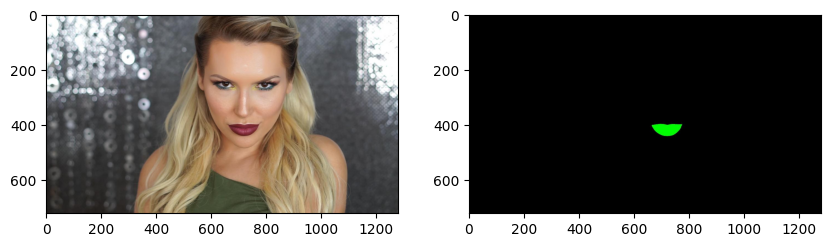

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[1].imshow(mask)
plt.show()

Напишем класс для подготовки данных:

In [32]:
class LipsDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.images = self.data.iloc[:, 0]
        self.masks = self.data.iloc[:, 1]
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        img = plt.imread(self.images[idx])
        mask = plt.imread(self.masks[idx])
        
        if self.preprocessing is not None:
            # Здесь будем использовать готовый обработчик для будущего энкодера,
            # к маске эти трансформации применять не будем
            img = self.preprocessing(img)
            
        img = transforms.ToTensor()(img)
        img = transforms.Resize((256, 256))(img)
        
        # Переводим 3 канала маски в один из максимальных значений
        mask = torch.max(torch.as_tensor(mask.copy()), axis=-1, keepdim=True).values.numpy()
        
        mask = transforms.ToTensor()(mask)
        mask = transforms.Resize((256, 256))(mask)
        
        return img.float(), mask
    
    def __len__(self):
        return len(self.data)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/maxim/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

Инициализируем сеть UNet с предобученным энкодером ResNet34:

In [34]:
torch.random.manual_seed(RANDOM_STATE)

unet = smp.Unet().to(device)
preprocessor = smp.encoders.get_preprocessing_fn('resnet34')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/maxim/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:07<00:00, 11.0MB/s]


Разделим данные на трейн и тест. Загрузим изображения, предобработав их  
готовым предобработчиком, настроенным для ResNet34:

In [35]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocessor)
test_data = LipsDataset(X_test, preprocessing=preprocessor)

Обозначим даталоадеры для обучения модели:

In [36]:
torch.random.manual_seed(RANDOM_STATE)

train_data_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=32,
                                                shuffle=True)

test_data_loader = torch.utils.data.DataLoader(test_data,
                                               batch_size=32,
                                               shuffle=False)

Сделаем энкодер необучаемым, т.к. мы уже взяли предобученные веса:

In [37]:
for i in unet.encoder.parameters():
    i.requires_grad = False

Посмотрим на общую картину сети:

In [38]:
summary(unet)

Layer (type:depth-idx)                        Param #
Unet                                          --
├─ResNetEncoder: 1-1                          --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    │    └─BasicBlock: 3-3                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-4                   (230,144)
│    │    └─BasicBlock: 3-5                   (295,424)
│    │    └─BasicBlock: 3-6                   (295,424)
│    │    └─BasicBlock: 3-7                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-8                   (919,040)
│    │    └─BasicBlock: 3-9                   (1,180

Нам нужно обучить более 3 млн. параметров декодера. Предобученный  
энкодер содержит более 21 млн. параметров.

В качестве лосса будем использовать DiceLoss. Единственная устраивающая  
нас метрика IoU требует на вход целые числа таргета. Посмотрим, устраивает  
ли это нас:

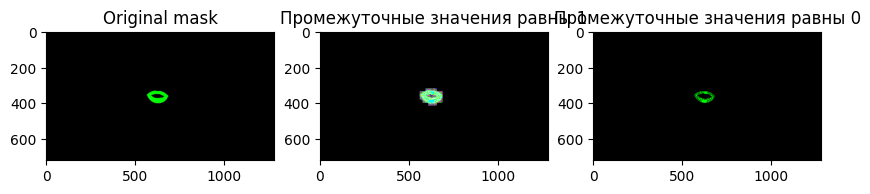

In [39]:
mask = plt.imread(masks[25])
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(mask)
axs[0].set_title('Original mask')
axs[1].imshow(np.where(mask == 0., 0., 1.))
axs[1].set_title('Промежуточные значения равны 1')
axs[2].imshow(np.where(mask == 1., 1., 0.))
axs[2].set_title('Промежуточные значения равны 0')

plt.show()

При установлении значений пикселей маски только в 0 и 1, маска  
явно теряет в качестве. Поэтому мы будем использовать значения,  
как и в исходных масках, т.е. от 0 до 1. Соответственно, IoU у  
нас работать не будет. Следовательно, будем опираться на лосс,  
который находится в интервале от 0 до 1, и вполне может быть  
интерпретирован как доля ошибки, хорошо заменяя метрику.

In [40]:
torch.backends.cudnn.deterministic = True
criterion = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(unet.parameters())

EPOCHS = 1

for epoch in range(EPOCHS):
    start_time = time.time()
    losses_train = 0.
    losses_test = 0.
    losses_test_counter = 0

    for batch_idx, (inputs, labels) in enumerate(train_data_loader):
        unet.train()
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = unet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses_train += loss.item()
        
        # Попытки использовать метрику IoU, в результате которых выяснилось,  
        # что она не принимает промежуточный таргет
        
        # outputs = unet(inputs)
        # tp, fp, fn, tn = smp.metrics.get_stats(outputs, labels, mode='binary')
        # iou_score = smp.metrics.iou_score(tp, fp, fn, tn)
        # metrics_train += iou_score

        if batch_idx % 100 == 0 or batch_idx == len(train_data_loader) - 1:
            print(f'Epoch [{epoch + 1}/{EPOCHS}]. ' \
                  f'Batch [{batch_idx + 1}/{len(train_data_loader)}]. '\
                  f'Train loss: {losses_train / (batch_idx + 1):.4f}. ', end='')
            
            with torch.inference_mode():
                unet.eval()
                
                for i, data in enumerate(test_data_loader):
                    inputs, labels = data[0].to(device), data[1].to(device)
                    outputs = unet(inputs)
                    loss = criterion(outputs, labels)
                    losses_test += loss.item()
            
            losses_test_counter += len(test_data_loader)
            print(f'Test loss: {losses_test / losses_test_counter:.4f}. '\
                  f'Time: {int(time.time() - start_time)} s')

print('Training is finished!')

/home/maxim/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/1]. Batch [1/714]. Train loss: 0.9923. Test loss: 0.9894. Time: 1289 s
Epoch [1/1]. Batch [101/714]. Train loss: 0.7478. Test loss: 0.6577. Time: 3995 s
Epoch [1/1]. Batch [201/714]. Train loss: 0.4446. Test loss: 0.4716. Time: 6424 s
Epoch [1/1]. Batch [301/714]. Train loss: 0.3249. Test loss: 0.3726. Time: 9632 s
Epoch [1/1]. Batch [401/714]. Train loss: 0.2613. Test loss: 0.3108. Time: 12034 s
Epoch [1/1]. Batch [501/714]. Train loss: 0.2217. Test loss: 0.2695. Time: 14500 s
Epoch [1/1]. Batch [601/714]. Train loss: 0.1945. Test loss: 0.2388. Time: 16954 s
Epoch [1/1]. Batch [701/714]. Train loss: 0.1745. Test loss: 0.2155. Time: 19435 s
Epoch [1/1]. Batch [714/714]. Train loss: 0.1722. Test loss: 0.1975. Time: 20692 s
Training is finished!


Посмотрим на результат обучения модели:

/home/maxim/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


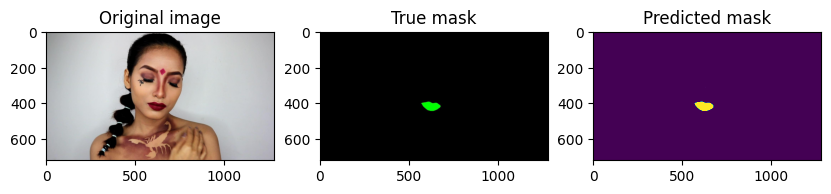

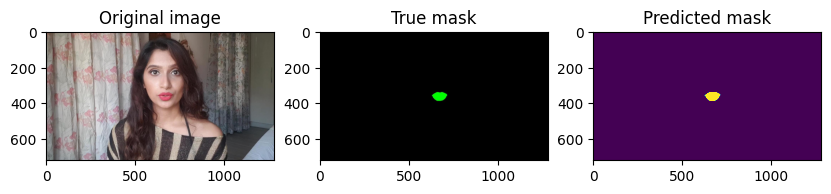

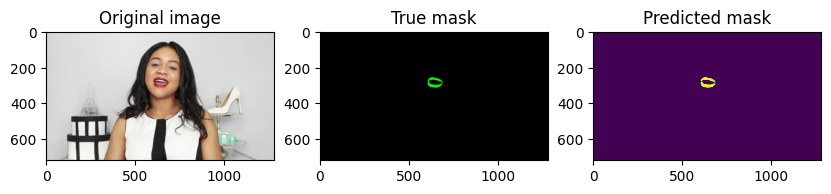

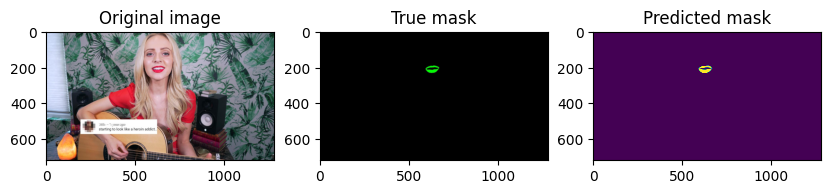

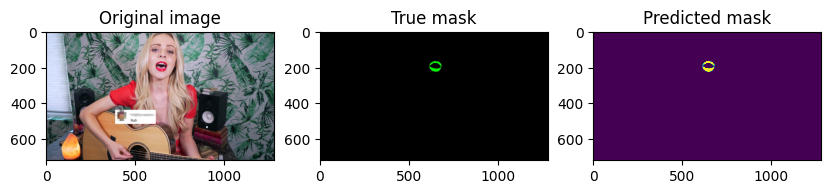

In [42]:
LIMIT = 5

imgs, masks = iter(test_data_loader).__next__()
for i in range(LIMIT):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(plt.imread(X_test['image'][i]))
    axs[0].set_title('Original image')
    axs[1].imshow(plt.imread(X_test['mask'][i]))
    axs[1].set_title('True mask')
    
    pred_mask = unet(torch.unsqueeze(imgs[i], 0).to(device)).to('cpu') # Делаем предсказание
    pred_mask = transforms.Resize((720, 1280))(pred_mask) # Возвращаем первоначальный размер картинки
    pred_mask = pred_mask[0, ...].permute(1, 2, 0)
    
    # Сделаем постобработку в виде нормализации, т.к. предсказанные маски
    # получили большой разброс значений, и фон получился слишком яркий
    axs[2].imshow(pred_mask.detach().numpy(), norm=colors.Normalize(vmin=-8, vmax=8))
    axs[2].set_title('Predicted mask')

Различие в цветовой гамме истинных и предсказанных масок связано с тем, что  
у истинных масок 3 канала цвета, а у предсказанных - всего один, и мы его  
изображаем в дефолтной cmap.  
Получили неплохой результат на одной эпохе обучения. Модель не вышла на  
плато лосса, и можно было бы ещё немного её дообучить путём добавления  
эпох и настройки learning_rate оптимизатора, но в таком случае нужно было  
бы внимательно следить за переобучением. В целом, задачу мы выполнили.